In [454]:
import networkx as nx
import osmnx as ox
import numpy as np
import warnings
warnings.filterwarnings('ignore')

MAP_PATH = "./data/london.graphml"

WALKING_SPEED = 1.34112 # m/s
WALKING_SPEED_MALE = 1.4 # m/s
WALKING_SPEED_FEMALE = 1.31 # m/s
WALKING_SPEED_YOUNG = 1.45 # m/s
WALKING_SPEED_OLD = 1.19 # m/s

WK_WEIGHT = 1

tube_speeds = [27.04, 37.29, 24.31, 29.44, 27.65, 40.32, 44.14, 34.09, 32.65, 42.49, 33.30]
TRANSPORT_SPEED =  (np.mean(tube_speeds) - 5) / 3.6 # km/h to m/s

In [455]:
# G = ox.graph_from_bbox(51.56, 51.48, -0.01, -0.16, network_type="walk")
# ox.save_graphml(G, MAP_PATH)

In [468]:
# G = ox.load_graphml(MAP_PATH)

# define origin/destination points
# origin_lat, origin_lon = 51.503556393676, -0.019542080948391778 # lat, lon
# dest_lat, dest_lon = 51.5283613, -0.13182
origin_address = 'Canary Wharf Station, London, UK'
dest_address = 'Euston, London, UK'
origin_lat, origin_lon = ox.geocode(origin_address)
dest_lat, dest_lon = ox.geocode(dest_address)
print(origin_lat, origin_lon)
print(dest_lat, dest_lon)

origin, dist1 = ox.nearest_nodes(G, origin_lon, origin_lat, return_dist=True)
dest, dist2 = ox.nearest_nodes(G, dest_lon, dest_lat, return_dist=True)


51.50360275 -0.019480738685344882
51.5282865 -0.1338745


In [457]:
# add weights to walking edges based on age/gender
for u, v, k, data in G.edges(data=True, keys=True):
    data['color'] = '#AAFF00'
    distance = data["length"]
    data["time"] = data["time_fake"] = round(distance / WALKING_SPEED * WK_WEIGHT)
    data["time_male"] = round(distance / WALKING_SPEED_MALE)
    data["time_female"] = round(distance / WALKING_SPEED_FEMALE)
    data["time_young"] = round(distance / WALKING_SPEED_YOUNG)
    data["time_old"] = round(distance / WALKING_SPEED_OLD)
    # print(f"distance: {round(data['length'], 3)} m \twk time: {round(data['time_old'], 3)} seconds (old)")
    # print(f"distance: {round(data['length'], 3)} m \twk time: {round(data['time_female'], 3)} seconds (female)")
    # print(f"distance: {round(data['length'], 3)} m \twk time: {round(data['time'], 3)} seconds (google)")
    # print(f"distance: {round(data['length'], 3)} m \twk time: {round(data['time_male'], 3)} seconds (male)")
    # print(f"distance: {round(data['length'], 3)} m \twk time: {round(data['time_young'], 3)} seconds (young)")

In [458]:
import json

with open('input/LondonTubeLines_minimal.json', 'r') as f:
    data = json.load(f)

tube_lines, route_colors = [], []
stations_osmid = set()
# Iterating through the json list
for tube_route in data['features']:
    start_end = tube_route['geometry']['coordinates']
    orig_lon, orig_lat = start_end[0][0], start_end[0][1]
    end_lon, end_lat = start_end[1][0], start_end[1][1]

    orig_node, dist1 = ox.nearest_nodes(G, orig_lon, orig_lat, return_dist=True)
    end_node, dist2 = ox.nearest_nodes(G, end_lon, end_lat, return_dist=True)

    stations_osmid.add(orig_node)
    stations_osmid.add(end_node)

    # ignore stations and routes that are not within 50m of the graph
    if dist1 > 50 or dist2 > 50:
        continue

    line_color = tube_route['properties']['stroke']
    feature_str = tube_route['properties']['name'].split(' - ')
    line_name = feature_str[0]
    start_station_name = feature_str[1].split(' to ')[0].split(' (')[0]
    end_station_name = feature_str[1].split(' to ')[1].split(' (')[0]

    # add line info to start station
    G.nodes[orig_node]['station_name'] = start_station_name

    try: 
        G.nodes[orig_node]['lines_color'].add(line_color)
        G.nodes[orig_node]['lines_name'].add(line_name)
    except (KeyError, AttributeError) as e:
        G.nodes[orig_node]['lines_color'] = {line_color}
        G.nodes[orig_node]['lines_name'] = {line_name}

    # add line info to end station
    G.nodes[end_node]['station_name'] = end_station_name

    try: 
        G.nodes[end_node]['lines_color'].add(line_color)
        G.nodes[end_node]['lines_name'].add(line_name)
    except (KeyError, AttributeError) as e:
        G.nodes[end_node]['lines_color'] = {line_color}
        G.nodes[end_node]['lines_name'] = {line_name}

    # print(f"{G.nodes[orig_node]['station_name']}: {G.nodes[orig_node]['lines_name']}")
    # print(f"{G.nodes[end_node]['station_name']}: {G.nodes[end_node]['lines_name']}")

    G.add_edge(orig_node, end_node, color=tube_route['properties']['stroke'])
    tube_lines.append(nx.shortest_path(G, orig_node, end_node))
    route_colors.append(tube_route['properties']['stroke'])

ox.distance.add_edge_lengths(G)

In [459]:
# add weight to tp edges
for u, v, k, data in G.edges(data=True, keys=True):
    if 'time' not in data:
        data['travel_mode'] = 'tp'
        data["time"] = data["time_male"] = data["time_female"] = data["time_young"] = data["time_old"] = data["length"] / TRANSPORT_SPEED
        # data["time_fake"] = data["length"] / TRANSPORT_SPEED_FAKE
        print(f"distance: {round(data['length'], 3)} m \ttp time: {round(data['time'], 3)} seconds")

distance: 964.899 m 	tp time: 120.263 seconds
distance: 921.038 m 	tp time: 114.796 seconds
distance: 1051.346 m 	tp time: 131.038 seconds
distance: 2004.636 m 	tp time: 249.854 seconds
distance: 871.459 m 	tp time: 108.617 seconds
distance: 784.023 m 	tp time: 97.719 seconds
distance: 784.023 m 	tp time: 97.719 seconds
distance: 600.979 m 	tp time: 74.905 seconds
distance: 600.979 m 	tp time: 74.905 seconds
distance: 789.288 m 	tp time: 98.375 seconds
distance: 696.197 m 	tp time: 86.773 seconds
distance: 696.197 m 	tp time: 86.773 seconds
distance: 197.281 m 	tp time: 24.589 seconds
distance: 295.622 m 	tp time: 36.846 seconds
distance: 608.24 m 	tp time: 75.81 seconds
distance: 673.803 m 	tp time: 83.981 seconds
distance: 916.166 m 	tp time: 114.189 seconds
distance: 838.866 m 	tp time: 104.555 seconds
distance: 415.025 m 	tp time: 51.728 seconds
distance: 1216.424 m 	tp time: 151.613 seconds
distance: 1228.435 m 	tp time: 153.11 seconds
distance: 1945.564 m 	tp time: 242.491 second

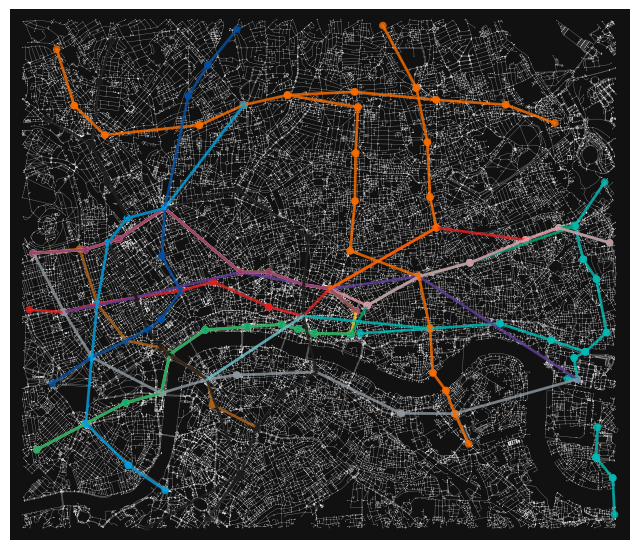

In [469]:
# plot london tube maps on top of walking map
# fig, ax = ox.plot_graph_routes(G, tube_lines, route_linewidths=2, route_colors=route_colors, route_alpha=.8, \
#                                node_color='w', node_size=.2, orig_dest_size=30, edge_linewidth=0.3, edge_color="dimgrey", edge_alpha=.7, \
#                                dpi=300)

# fig.savefig("output/map_central.png", dpi=300, bbox_inches='tight')

In [461]:
# define origin/destination points
# origin_lat, origin_lon = 51.503556393676, -0.019542080948391778 # lat, lon
# dest_lat, dest_lon = 51.5283613, -0.13182

# origin, dist1 = ox.nearest_nodes(G, origin_lon, origin_lat, return_dist=True)
# dest, dist2 = ox.nearest_nodes(G, dest_lon, dest_lat, return_dist=True)

route = nx.shortest_path(G, origin, dest, weight="time")
print(route)
# all_routes = nx.shortest_paths.all_shortest_paths(G, orig_node, end_node, weight="time", method="dijkstra")

# id = 0
# for n in G.edges:
#     id += 1
#     print(n, G.edges[n]['time'])
#     if id == 120:
#         break

# for route in all_routes:
#     print(route)

[7600075680, 7600075682, 7600075684, 7600075679, 3491457582, 3706009929, 3799581739, 3799581741, 3725009495, 2058294362, 10219897128, 1881069678, 1888070097, 2036165262, 10252978209, 662564103, 1813788448, 1813788435, 1813788414, 1813788417, 5946284332, 10841775583, 453305691, 4161294817, 5473273796, 8898783674, 5479654175, 700169540, 2428147220, 1264708174, 1760542333]


In [470]:
# plot route with diff colours for diff transport modes
recommended_routes = []
recommended_routes_color = []
transfer = 0

print(f"Start at : {origin_address}")

last_travel_mode = 'walk'
last_travel_stop = origin
last_station = ''

for i in range(len(route)-1):
    start_node, end_node = route[i], route[i+1]
    recommended_routes.append([start_node, end_node])
    if 'lines_name' in G.nodes[start_node] and 'lines_name' in G.nodes[end_node]:
        tube_line = set.intersection(G.nodes[start_node]['lines_name'], G.nodes[end_node]['lines_name']).pop()
        recommended_routes_color.append(set.intersection(G.nodes[start_node]['lines_color'], G.nodes[end_node]['lines_color']).pop())
        if last_travel_mode != 'walk' and last_travel_mode != tube_line:
            print(f"   -> to [{last_station}]")
        last_station = G.nodes[end_node]['station_name']
        travel_mode = tube_line
    else:
        travel_mode = 'walk'
        recommended_routes_color.append('springgreen')
    
    if last_travel_mode != travel_mode:
        transfer += 1
        if last_travel_mode == 'walk':
            print(f"{transfer}. 🚄 From [{G.nodes[start_node]['station_name']}] take {tube_line} line")
        elif travel_mode == 'walk':
            if last_station != '':
                print(f'   -> Get off at [{last_station}]')
            print(f'{transfer}. 🚶🏻 Walk')
        else:
            print(f"{transfer}. 🚄 Change at [{G.nodes[start_node]['station_name']}] to {tube_line} line")

    last_travel_mode = travel_mode

print(f"Reaching destination: {dest_address}")
print(f"Transfers: {transfer} times")
# fig, ax = ox.plot_graph_routes(G, recommended_routes, route_linewidths=2, route_colors=recommended_routes_color, route_alpha=.8, \
#                             node_color='w', node_size=.2, orig_dest_size=30, edge_linewidth=0.3, edge_color="dimgrey", edge_alpha=.7, \
#                             bbox=(51.54, 51.49, -0.016, -0.14), dpi=300, ax=ax)

# fig.savefig("output/route_c.png", dpi=300, bbox_inches='tight')

# plot whole route
# fig, ax = ox.plot_graph_route(G, route, route_linewidth=3, route_color="springgreen", route_alpha=1, node_size=.2, orig_dest_size=50, \
#                               edge_linewidth=0.3, edge_color="dimgrey", edge_alpha=.7, \
#                               dpi=300, ax=ax)
# fig.savefig("output/map_pad_bush.png", dpi=300, bbox_inches='tight')

Start at : Canary Wharf Station, London, UK
1. 🚄 From [Poplar] take DLR line
   -> to [Bank]
2. 🚄 Change at [Bank] to Northern line
   -> to [Moorgate]
3. 🚄 Change at [Moorgate] to Metropolitan line
   -> to [Kings Cross St. Pancras]
4. 🚄 Change at [Kings Cross St. Pancras] to Victoria line
   -> Get off at [Euston]
5. 🚶🏻 Walk
Reaching destination: Euston, London, UK
Transfers: 5 times


In [463]:
# total_time = nx.dijkstra_path_length(G, orig_node, end_node, weight="time")
# print(f"Total time: {round(total_time/60, 3)} minutes")
# total_time = nx.dijkstra_path_length(G, orig_node, end_node, weight="time_old")
# print(f"Total time: {round(total_time/60, 3)} minutes (old)")
# total_time = nx.dijkstra_path_length(G, orig_node, end_node, weight="time_female")
# print(f"Total time: {round(total_time/60, 3)} minutes (female)")
# total_time = nx.dijkstra_path_length(G, orig_node, end_node, weight="time_male")
# print(f"Total time: {round(total_time/60, 3)} minutes (male)")
# total_time = nx.dijkstra_path_length(G, orig_node, end_node, weight="time_young")
# print(f"Total time: {round(total_time/60, 3)} minutes (young)")

In [464]:
original_waypoints = [{'lat': 51.51629149999999, 'lng': -0.1755034}, {'lat': 51.507504, 'lng': -0.128672}, {'lat': 51.5076022, 'lng': -0.1289566}, {'lat': 51.5128431, 'lng': -0.1185001}, {'lat': 51.51305350000001, 'lng': -0.1175648}]
alt1_waypoints = [{'lat': 51.516482, 'lng': -0.1779082}, {'lat': 51.5143352, 'lng': -0.1488549}, {'lat': 51.5145647, 'lng': -0.1473793}]
alt2_waypoints = [{'lat': 51.51439999999999, 'lng': -0.149408}, {'lat': 51.517746, 'lng': -0.119719}, {'lat': 51.51305350000001, 'lng': -0.1175648}]
original_travel_modes = [('Walking', 'Walk to Paddington'), ('Transit', 'Subway'), ('Walking', 'Walk to Trafalgar Square (Stop B)'), ('Transit', 'Bus'), ('Walking', 'Walk to 30 Aldwych, London WC2B 4BG, UK')]
alt1_travel_modes = [('Walking', 'Walk to Paddington'), ('Transit', 'Train'), ('Walking', 'Walk to Bond Street, Bond Street Station Underground Ltd, Oxford St, London W1R 1FE, UK')]
alt2_travel_modes = [('Walking', 'Walk to Bond Street'), ('Transit', 'Subway'), ('Walking', 'Walk to 30 Aldwych, London WC2B 4BG, UK')]

# plot routes

# paths = []
# route_colors = []
# for i in range(1, len(original_waypoints)):
#     origin = original_waypoints[i-1]['lng'], original_waypoints[i-1]['lat']
#     end = original_waypoints[i]['lng'], original_waypoints[i]['lat'] # find the nearest node to the start location
#     orig_node = ox.nearest_nodes(G, origin[0], origin[1])
#     end_node = ox.nearest_nodes(G, end[0], end[1])
#     if original_travel_modes[i][0] == "Walking":
#         route_colors.append("cornflowerblue")
#     else:
#         route_colors.append("gainsboro")
        
#     paths.append(nx.dijkstra_path(G, orig_node, end_node, weight="time"))
    
# # print(G.edges)
# fig, ax = ox.plot_graph_routes(G, paths, route_linewidths=3, route_colors=route_colors, route_alpha=.9, node_color='dimgrey', \
#                                edge_linewidth=0.3, edge_alpha=.7, edge_color="dimgrey", orig_dest_size=50, node_size=.4, \
#                                 bbox=(51.535, 51.49, -0.08457, -0.183919), dpi=300, ax=ax)
# # fig, ax = ox.plot_graph_routes(G, paths, route_linewidth=2, route_color=route_colors, route_alpha=1, node_size=.2)

# fig.savefig("output/map_original_bush_house.png", dpi=300, bbox_inches='tight')
# fig.clf()


# paths = []
# route_colors = []
# alt_waypoints = alt1_waypoints + alt2_waypoints
# alt_travel_modes = alt1_travel_modes + alt2_travel_modes
# for i in range(1, len(alt_waypoints)):
#     origin = alt_waypoints[i-1]['lng'], alt_waypoints[i-1]['lat']
#     end = alt_waypoints[i]['lng'], alt_waypoints[i]['lat']# find the nearest node to the start location
#     orig_node = ox.nearest_nodes(G, origin[0], origin[1])
#     end_node = ox.nearest_nodes(G, end[0], end[1])
#     if alt_travel_modes[i][0] == "Walking":
#         route_colors.append("springgreen")
#     else:
#         route_colors.append("gainsboro")
        
#     paths.append(nx.dijkstra_path(G, orig_node, end_node, weight="time"))

# fig, ax = ox.plot_graph_routes(G, paths, route_linewidths=3, route_colors=route_colors, route_alpha=.9, node_color='dimgrey', \
#                                edge_linewidth=0.3, edge_alpha=.7, edge_color="dimgrey", orig_dest_size=50, node_size=.4, \
#                                 bbox=(51.535, 51.49, -0.08457, -0.183919), dpi=300, ax=ax)

# # fig, ax = ox.plot_graph_routes(G, paths, route_linewidth=2, route_color=route_colors, route_alpha=1, node_size=.2, orig_dest_size=50, \
# #                               edge_linewidth=0.3, edge_color="dimgrey", edge_alpha=.7, dpi=300)

# fig.savefig("output/map_alt_bush_house.png", dpi=300, bbox_inches='tight')